## Perform some exploratory data analysis on the ECG datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import os
import sys

from model_definitions import stanford_resnet
from data_processing import load_data, get_single_input, get_class_data

In [2]:
# Load in Datasets

train_data, train_labels = load_data("./archive/mitbih_train.csv")
train_data = np.expand_dims(train_data, axis=2)
test_data, test_labels = load_data("./archive/mitbih_test.csv")
train_data = np.expand_dims(train_data, axis=2)

class_names = [
    'Normal Beat', 
    'Supraventricular Premature Beat',
    'Premature Ventricular Contraction',
    'Fusion of Ventricular and Normal Beat',
    'Unclassifiable Beat']

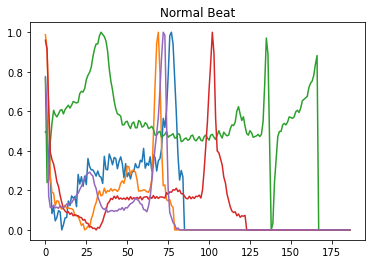

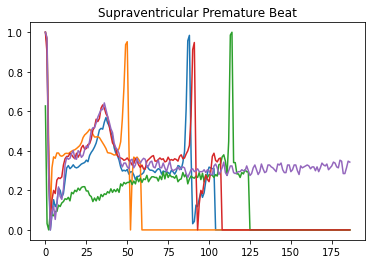

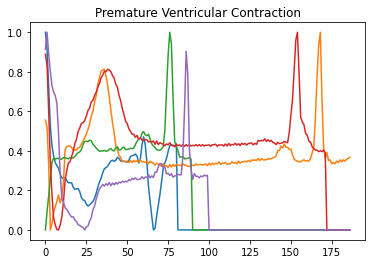

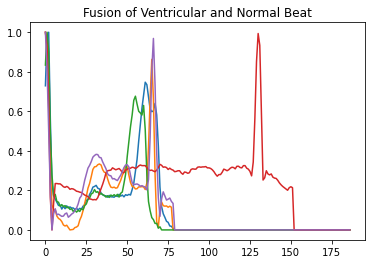

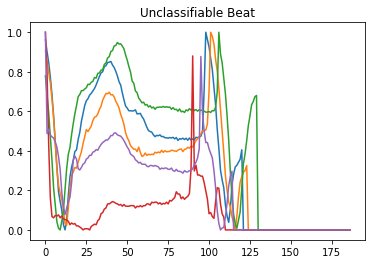

In [3]:
def plot_class(test_data, test_labels, obj_class, number, class_names):
    indices = np.where(test_labels==obj_class)
    plt.figure()
    plt.title('{}'.format(class_names[obj_class]))
    samples = np.random.choice(indices[0], number, replace=False)
    for i in samples:
        plt.plot(test_data[i,:,0])
    plt.show()
    return

# Look at a few examples for each of the object classes
plot_class(train_data,train_labels,0,5, class_names)
plot_class(train_data,train_labels,1,5, class_names)
plot_class(train_data,train_labels,2,5, class_names)
plot_class(train_data,train_labels,3,5, class_names)
plot_class(train_data,train_labels,4,5, class_names)

One initial consideration is the padded zeros at the end of many of the data samples. If there is a specific class that has a longer 'tail' when compared to the remaining classes, a model may pick up a bias to classifying that particular class based soley on the trailing zeros.

Given that the trailing zeros are not representing real data, this would be problematic for classifying true cases where such data is not present. 

Look for trends within each object class.

(13552077,)


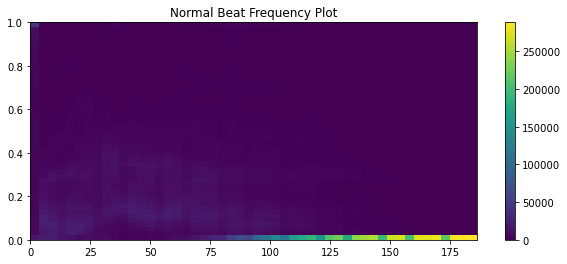

(415701,)


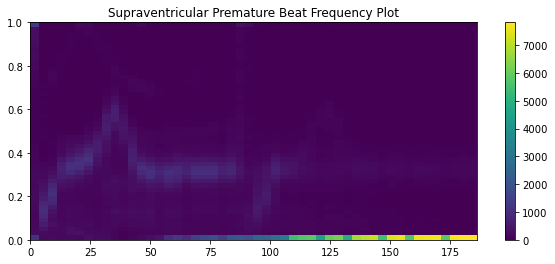

(1082356,)


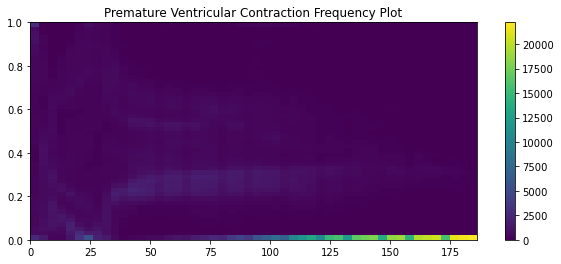

(119867,)


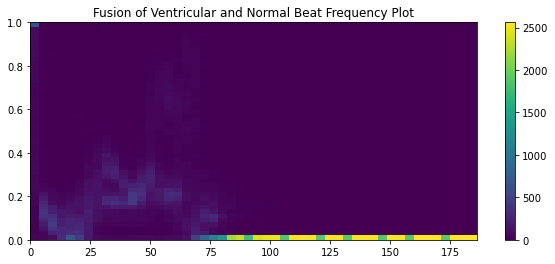

(1202597,)


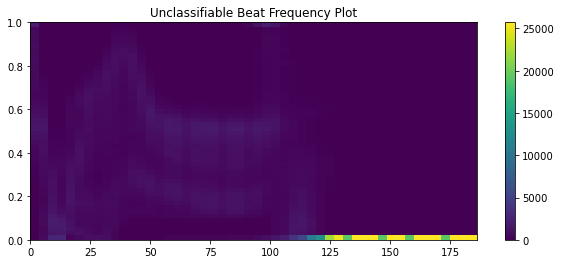

In [24]:
# Create a 2D histogram plot for each object class to look at trends for each object class
num_bins=50
for i in range(5):
    class_data = get_class_data(train_data, train_labels, object_class=i)
    x_data = np.zeros((class_data.shape[0],class_data.shape[1]))
    
    for j in range(class_data.shape[0]):
        x_data[j,:] = np.arange(0,class_data.shape[1])
    x_data = x_data.flatten()
    class_data = class_data.flatten()
    print(x_data.shape)
    plt.figure(figsize=(10,4))
    plt.hist2d(x_data,class_data, bins=(num_bins,num_bins)) #norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.title('{} Frequency Plot'.format(class_names[i]))
    plt.show()

Each class appears to have a significant amount of zeros which overwhelms the frequency plots.
Removing the trailing zeros at the end of each input may give a better representation of each object class

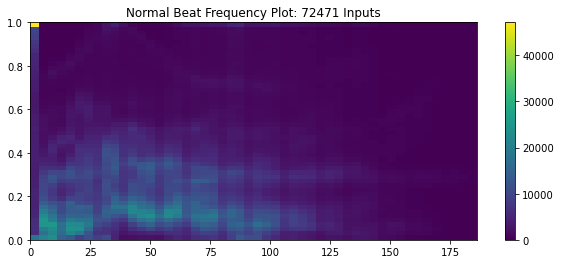

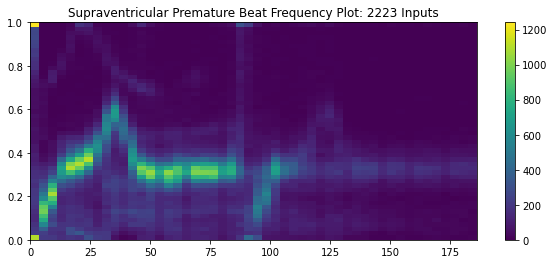

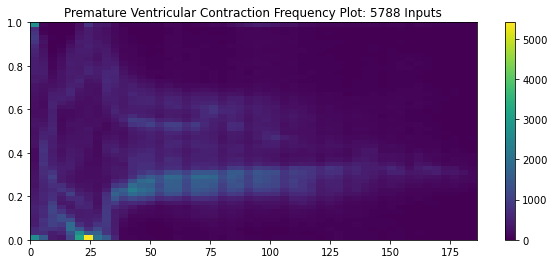

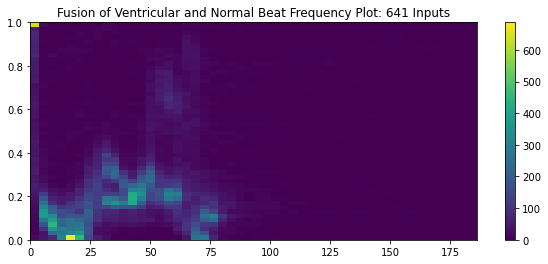

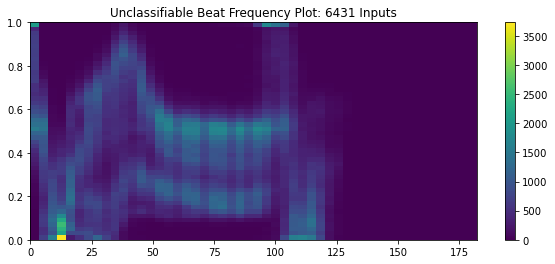

In [50]:
# Create a 2D histogram plot for each object class to look at trends for each object class
num_bins=50
for i in range(5):
    class_data = get_class_data(train_data, train_labels, object_class=i)
    # Initialize array to save time from multiple concatenates
    trim_data = np.zeros(class_data.shape[0]*class_data.shape[1])
    x_data = np.zeros(class_data.shape[0]*class_data.shape[1])
    ind = 0
    for j in range(class_data.shape[0]):
        temp = np.trim_zeros(class_data[j,:,0], trim='b')
        ind_end = ind + len(temp)
        trim_data[ind:ind_end] = temp
        x_data[ind:ind_end] = np.arange(0,len(temp))
        ind = ind_end
        
    x_data = np.trim_zeros(x_data, trim='b')
    trim_data = np.trim_zeros(trim_data, trim='b')

    
    plt.figure(figsize=(10,4))
    plt.hist2d(x_data,trim_data, bins=(num_bins,num_bins))
    plt.colorbar()
    plt.title('{} Frequency Plot: {} Inputs'.format(class_names[i], class_data.shape[0]))
    plt.show()

A few things to note about the dataset:

    - It appears that a significant protion of inputs start off at 1 for every class
    - Class 4 (Fusion of Ventricular and Normal Beat) appears to have the shortest inputs compared to the other classes
    - Class 3, 4, and 5 all have a single point that is highly present across each sample at timestep 12-25
    

Use UMAP dimension reduction algorithm to plot separability of classes.

In [53]:
print(train_data.shape)
umap_train_data = train_data.squeeze()
print(umap_train_data.shape)

(87554, 187, 1, 1)
(87554, 187)


In [54]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(umap_train_data)
print(embedding.shape)


(87554, 2)


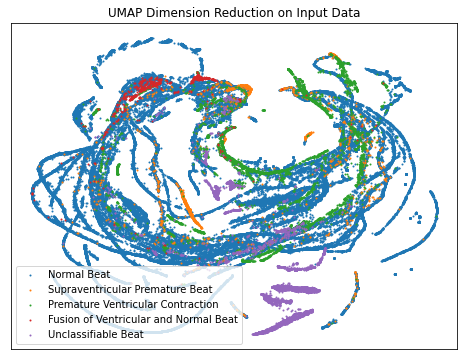

In [74]:


fig, ax = plt.subplots(figsize=(8,6))
for i in range(5):
    indices = np.where(train_labels==i)
    temp_emb = embedding[indices[0],:]
    ax.plot(temp_emb[:,0], temp_emb[:,1], label=class_names[i], marker='.', ms=2, linestyle='')

ax.legend()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_title('UMAP Dimension Reduction on Input Data')
plt.show()


The UMAP Dimensional Reduction shows that the inputs to the model are not highly separable to begin with, with a significant amount of overlab between the different classes.